In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import math
import statsmodels.api as sm
from functions import load_and_clean_csv

In [2]:
url = "amz_uk_price_prediction_dataset.csv"
df = load_and_clean_csv(url)
df.head()

,uid,asin,title,stars,reviews,price,isbestseller,boughtinlastmonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [3]:
df["isbestseller"] = df["isbestseller"].replace({"False": 0, "True": 1})

## Part 1: Analyzing Best-Seller Trends Across Product Categories


# Crosstab Analysis

In [4]:
# Create the crosstab of product category and isBestSeller
crosstab = pd.crosstab(df['category'], df['isbestseller'])

# Check the column names in crosstab
print(crosstab.columns)

# If the columns are boolean (True/False), use the correct labels in the calculation:
if 'True' in crosstab.columns or True in crosstab.columns:  # Handle possible variations
    crosstab['proportion_best_sellers'] = crosstab[True] / (crosstab[False] + crosstab[True])
else:
    # Adjust for any other variation in column names
    crosstab['proportion_best_sellers'] = crosstab[1] / (crosstab[0] + crosstab[1])

# Sort categories by proportion of best-sellers
sorted_crosstab = crosstab.sort_values(by='proportion_best_sellers', ascending=False)

print(sorted_crosstab)

Index([False, True], dtype='bool', name='isbestseller')
isbestseller                      False  True  proportion_best_sellers
category                                                              
Grocery                            9008   556                 0.058135
Smart Home Security & Lighting       98     6                 0.057692
Health & Personal Care             9017   552                 0.057686
Mobile Phone Accessories            248    11                 0.042471
Power & Hand Tools                 8353   306                 0.035339
...                                 ...   ...                      ...
CD, Disc & Tape Players            8798     0                 0.000000
General Music-Making Accessories    259     0                 0.000000
Snowboard Boots                    1449     0                 0.000000
Boxes & Organisers                  911     0                 0.000000
eBook Readers & Accessories         246     0                 0.000000

[296 rows x 3 column

# Chi-square test

In [5]:
chi2, p, dof, ex = chi2_contingency(crosstab.iloc[:, 0:2])
print(f"Chi-Square Test Results:\nChi2 = {chi2}, p-value = {p}, degrees of freedom = {dof}")

Chi-Square Test Results:
Chi2 = 36540.20270061387, p-value = 0.0, degrees of freedom = 295


Chi-Square Test: If the p-value is less than 0.05, we reject the null hypothesis, indicating that the distribution of best-seller status is dependent on the product category.

# Cramér's V Calculation

In [6]:
n = crosstab.values.sum() # total number of observations
cramers_v = math.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.08646706664522864


Cramér's V: A Cramér's V value closer to 0 means a weaker association

# Visualization

<Figure size 10000x200000 with 0 Axes>

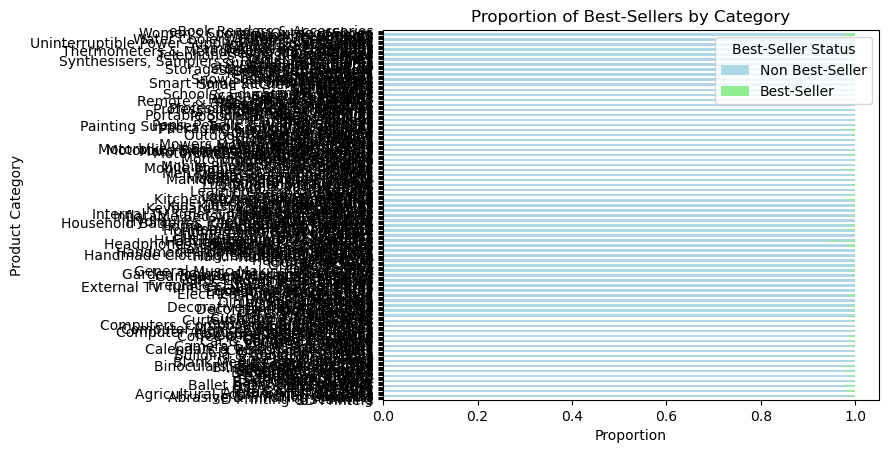

In [7]:
# Stacked Bar Chart
stacked_crosstab = crosstab.iloc[:, 0:2].div(crosstab.iloc[:, 0:2].sum(axis=1), axis=0)
plt.figure(figsize=(100, 2000)) 
stacked_crosstab.plot(kind='barh', stacked=True, color=['lightblue', 'lightgreen'])
plt.title('Proportion of Best-Sellers by Category')
plt.xlabel('Proportion')
plt.ylabel('Product Category')
plt.legend(title='Best-Seller Status', loc='upper right', labels=['Non Best-Seller', 'Best-Seller'])
plt.show()

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands


# Preliminary Step: Remove outliers in product prices.

In [8]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Violin Plots

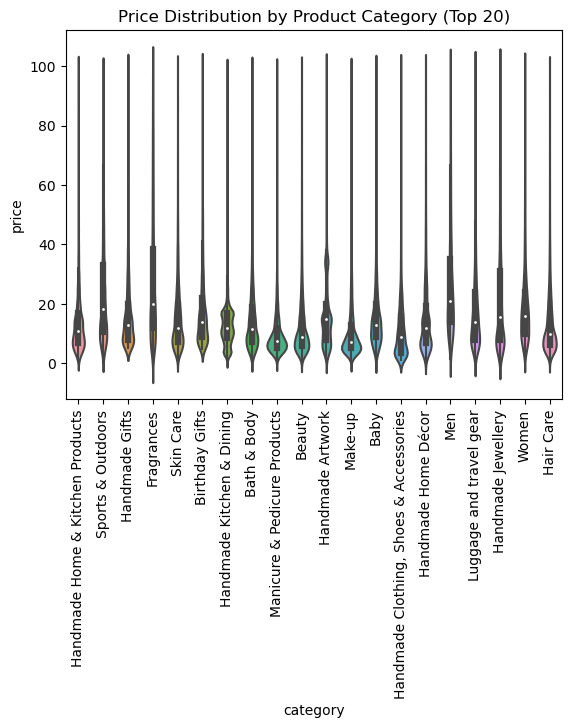

In [9]:
top_20_categories = df_filtered['category'].value_counts().nlargest(20).index
sns.violinplot(data=df_filtered[df_filtered['category'].isin(top_20_categories)], x='category', y='price')
plt.title('Price Distribution by Product Category (Top 20)')
plt.xticks(rotation=90)
plt.show()

In [10]:
# Highest median price category (without filtering)
median_prices = df.groupby('category')['price'].median()
highest_median_category = median_prices.idxmax()
highest_median_value = median_prices.max()
print(f"Highest median price category: {highest_median_category}, Median Price: {highest_median_value}")

Highest median price category: Laptops, Median Price: 1042.725


# Bar Charts

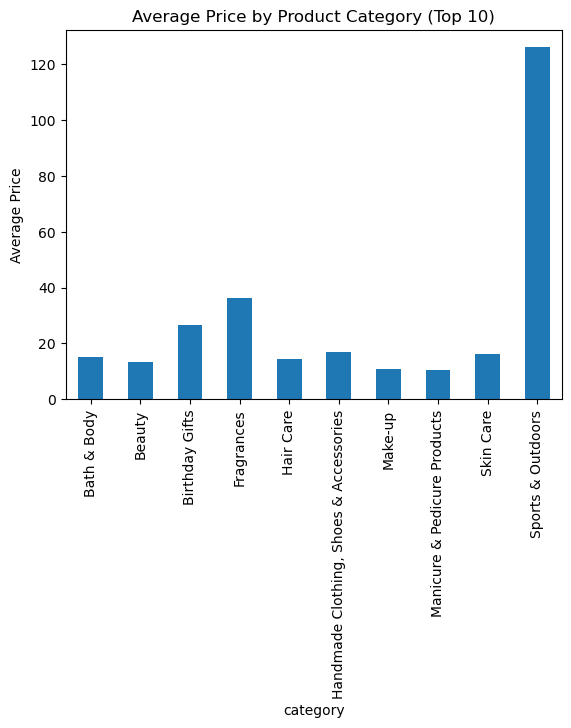

In [19]:
top_10_categories = df['category'].value_counts().nlargest(10).index
average_prices = df[df['category'].isin(top_10_categories)].groupby('category')['price'].mean()
average_prices.plot(kind='bar')
plt.title('Average Price by Product Category (Top 10)')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Highest average price category (without filtering)
highest_average_category = average_prices.idxmax()
highest_average_value = average_prices.max()
print(f"Highest average price category: {highest_average_category}, Average Price: {highest_average_value}")

Highest average price category: Sports & Outdoors, Average Price: 125.76981394653608


# Box Plots

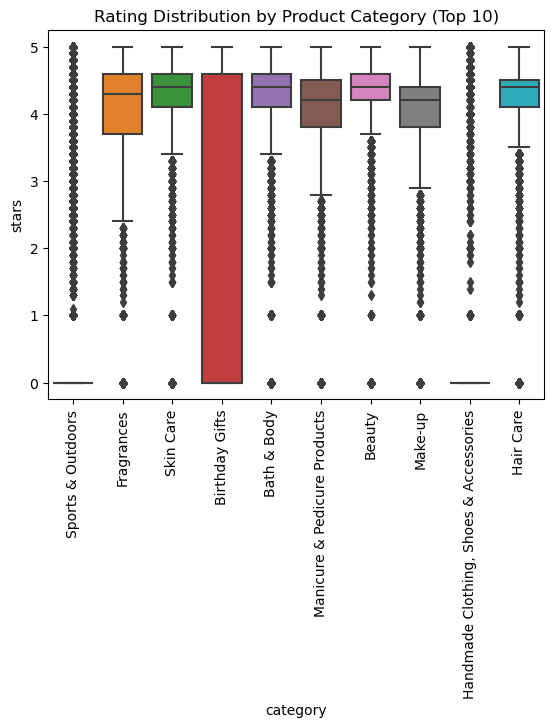

In [13]:
top_10_categories_ratings = df['category'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['category'].isin(top_10_categories_ratings)], x='category', y='stars')
plt.title('Rating Distribution by Product Category (Top 10)')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Highest median rating category (without filtering)
median_ratings = df.groupby('category')['stars'].median()
highest_median_rating_category = median_ratings.idxmax()
highest_median_rating_value = median_ratings.max()
print(f"Highest median rating category: {highest_median_rating_category}, Median Rating: {highest_median_rating_value}")

Highest median rating category: Computer Memory, Median Rating: 4.7


## Part 3: Investigating the Interplay Between Product Prices and Ratings

# Correlation Coefficients

In [15]:
correlation_coefficient = df['price'].corr(df['stars'])
print(f"Correlation coefficient between price and rating: {correlation_coefficient}")

# Determine if the correlation is significant
if abs(correlation_coefficient) > 0.5:  # arbitrary threshold for strong correlation
    print("There is a significant correlation between product price and its rating.")
else:
    print("There is no significant correlation between product price and its rating.")

Correlation coefficient between price and rating: -0.1249067326214861
There is no significant correlation between product price and its rating.


# Visualizations

Scatter Plot

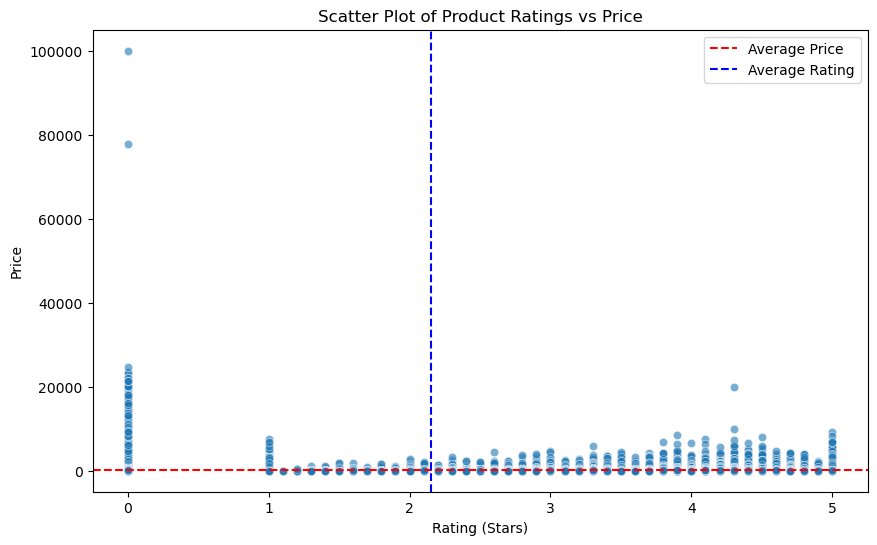

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='stars', y='price', alpha=0.6)
plt.title('Scatter Plot of Product Ratings vs Price')
plt.xlabel('Rating (Stars)')
plt.ylabel('Price')
plt.axhline(y=df['price'].mean(), color='r', linestyle='--', label='Average Price')
plt.axvline(x=df['stars'].mean(), color='b', linestyle='--', label='Average Rating')
plt.legend()
plt.show()

Correlation Heatmap

uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isbestseller            bool
boughtinlastmonth      int64
category              object
dtype: object


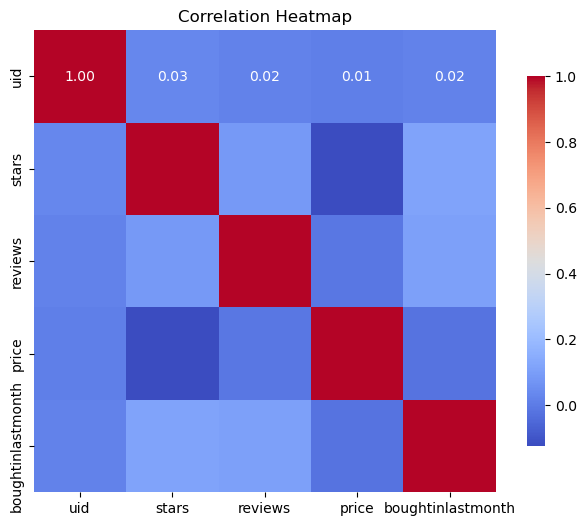

In [21]:
print(df.dtypes)

# Identify Non-Numeric Columns

numeric_df = df.select_dtypes(include=[np.number])

# If there are non-numeric columns that you want to convert to numeric, you can use:
# df['column_name'] = pd.to_numeric(df['column_name'], errors='coerce')

# Recalculate the Correlation Matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True
            cmap='coolwarm',
            fmt='.2f',
            square=True,
            cbar_kws={"shrink": .8},
            annot_kws={"size": 10})

plt.title('Correlation Heatmap')
plt.show()

QQ Plot

<Figure size 1000x600 with 0 Axes>

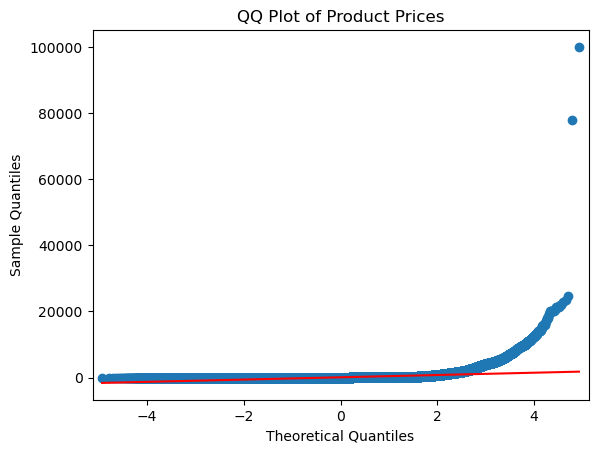

In [18]:
plt.figure(figsize=(10, 6))
sm.qqplot(df['price'], line='s')
plt.title('QQ Plot of Product Prices')
plt.show()